# Neural Networks

## Binary Classification with Tensor Flow (*Keras*)

In [162]:
# Keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import relu, softmax, sigmoid, tanh 
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy
from keras.losses import mean_absolute_error
from keras.metrics import accuracy, Precision
from keras.optimizers import Adam, SGD, RMSprop
from keras.initializers import GlorotNormal, RandomNormal, RandomUniform, VarianceScaling

In [436]:
import torch.utils.data as data_utils
import torch
from torch import nn 

In [220]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import re
from operator import getitem

In [133]:
# Load the data
data_crime = pd.read_stata(r'./data_dta/CRIME1.dta')
# Metadata --> http://eswf.uni-koeln.de/daten/crime1.html

# Generate the variable arr86, which a person is labeled equal to 0, if he or she has not arrested in 1986
# otherwise 1.
data_crime['arr86'] = np.where(data_crime.narr86 == 0, data_crime.narr86, 1)

In [231]:
arr86_columns = data_crime.columns.str.match(r'(?:n(?:f|p)?)?arr86$')
# Remove the arr86 columns
columns_arr86_removed = data_crime.columns[~ arr86_columns]

categorical = ['ptime86']
dummies = ['black', 'hispan', 'born60']
is_not_continuous = columns_arr86_removed.isin(dummies + categorical)
continuous = columns_arr86_removed[~is_not_continuous]
target =  'arr86'

In [439]:
class GetData:
    def __init__(self, dataframe, target, categorical=[], continuous=[], dummies=[], how='train') -> None:
        
        self.df = dataframe
        self.target = target
        self.categorical = categorical
        self.continuous = continuous
        self.dummies = dummies
        self.how = how

    def convert_to_dummies(self, dataframe, categorical):
    
        dummies_list = [pd.get_dummies(dataframe[cat], prefix=cat) for cat in categorical]
        if len(dummies_list)>1:
            return pd.concat(dummies_list, axis=1)
        else:
            return getitem(dummies_list, 0)
    
    def transform_continuous(self, dataframe, continuous):
        self.scaler = StandardScaler()
        self.scaler.fit(dataframe[continuous])
        df_cont = self.scaler.transform(dataframe[continuous])
        out = pd.DataFrame(df_cont, columns=[cont + '_standard' for cont in continuous])
        return out

    def transform_data_and_split(self):
        
        # Features
        list_vars = []
        if len(self.categorical) >= 1:
            data_dummies = self.convert_to_dummies(self.df, self.categorical)
            list_vars.append(data_dummies)
        
        if len(self.continuous) >= 1 :
            data_scaled = self.transform_continuous(self.df, self.continuous)
            list_vars.append(data_scaled)
        if len(dummies)>=1:
            list_vars.append(self.df[dummies])
        
        assert len(list_vars)>=1, "No exists features"
        
        if len(list_vars)>1:
            X_trans = pd.concat(list_vars, axis=1).astype(np.float32).values
        
        else:
            X_trans = getitem(list_vars, 0).astype(np.float32).values
        

        y = data_crime[self.target]
        # ohe = OneHotEncoder(sparse_output=False)
        y_trans = y.astype(np.int32).values
        # Target
        if self.how == 'train':
            
            X_train, X_test, y_train, y_test = train_test_split(X_trans,
                                                    y_trans,
                                                    test_size=0.25,
                                                    random_state=1234)
            return X_train, X_test, y_train, y_test
        else:
            X_to_predict, y_to_predict = X_trans.copy(), y_trans.copy()

            return X_to_predict, y_to_predict

    def from_df_to_loader(self, X, y, batch_size):
        X_torch = torch.from_numpy(X)
        y_torch = torch.from_numpy(y)
        y_torch = y_torch.type(torch.int64)
        dataset = data_utils.TensorDataset(X_torch, y_torch)
        loader = data_utils.DataLoader(dataset, batch_size=batch_size)
        return loader

    def to_torch(self):
        if self.how == 'train':
            X_train, X_test, y_train, y_test = self.transform_data_and_split()
            train_loader = self.from_df_to_loader(X_train, y_train, 10)
            test_loader = self.from_df_to_loader(X_test, y_test, 10)
            
            return train_loader, test_loader
        else:
            X_to_predict, y_to_predict = self.transform_data_and_split()
            train_loader = self.from_df_to_loader(X_to_predict, y_to_predict, 10)


In [440]:
getdata = GetData(data_crime,target, categorical, continuous, dummies)
train_loader, test_loader = getdata.to_torch()

In [444]:
for X, y in train_loader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([10, 26])
torch.Size([10])


In [445]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )

    def forward(self, x):
        # x = self.flatten(x)
        
        logits = self.linear_relu_stack(x)
        # --> shape --> (10, 2)
        return logits


model = NeuralNetwork()
model.to(device)
print(model)

Using cpu device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)


In [446]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [451]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # pred => (10, 2)
        pred = model(X)
        
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, cumm = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{cumm:>5d}/{size:>5d}]")

In [452]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [453]:
epochs = 200
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.378230  [    0/ 2043]
loss: 0.395267  [ 1000/ 2043]
loss: 0.804306  [ 2000/ 2043]
Test Error: 
 Accuracy: 70.7%, Avg loss: 0.584692 

Epoch 2
-------------------------------
loss: 0.376952  [    0/ 2043]
loss: 0.394415  [ 1000/ 2043]
loss: 0.804112  [ 2000/ 2043]
Test Error: 
 Accuracy: 70.7%, Avg loss: 0.583954 

Epoch 3
-------------------------------
loss: 0.375664  [    0/ 2043]
loss: 0.393549  [ 1000/ 2043]
loss: 0.803948  [ 2000/ 2043]
Test Error: 
 Accuracy: 70.7%, Avg loss: 0.583206 

Epoch 4
-------------------------------
loss: 0.374364  [    0/ 2043]
loss: 0.392719  [ 1000/ 2043]
loss: 0.803793  [ 2000/ 2043]
Test Error: 
 Accuracy: 70.7%, Avg loss: 0.582450 

Epoch 5
-------------------------------
loss: 0.373056  [    0/ 2043]
loss: 0.391875  [ 1000/ 2043]
loss: 0.803664  [ 2000/ 2043]
Test Error: 
 Accuracy: 70.7%, Avg loss: 0.581683 

Epoch 6
-------------------------------
loss: 0.371734  [    0/ 2043]
loss: 0.391028  [ 10

In [460]:
with torch.no_grad():
    for X, y in test_loader:
        pred = model(X)
        print(pred.argmax(1))
        print(y)

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 1, 1, 1])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 0, 0, 1, 1, 0, 1, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0,

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

In [1]:
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow import keras
import tensorflow as tf
from sklearn.datasets import make_moons

from time import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras import activations

In [6]:
Sequential = keras.models.Sequential
Dense, Flatten = keras.layers.Dense, keras.layers.Flatten
activations = keras.activations

## Tensor Flow for Classification

Data used `Fashion`

In [2]:
# Load files

fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print('The dimention of features ({1}, {2}) by each {0} rows'.format(*X_train_full.shape))
print("dtype",X_train_full.dtype)

The dimention of features (28, 28) by each 60000 rows
dtype uint8


* The first observation of `y_train_full` show `0`. This number represent a type of clothes.
* The first observation of `X_train_full` is a matrix `2d` of `28x28`. In this matrix was convert the image of the clothes.

In [3]:
# Create data for validation
# The first 5000 rows is for validation, while the next 55000 rows is for training
# We divide by 255 for work with scale the pixel intensities down to the 0-1 range

X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

print('The dimention of features ({1}, {2}) by each {0} rows'.format(*X_train.shape))
print('The dimention of target is ({},) rows'.format(*y_train.shape))

The dimention of features (28, 28) by each 55000 rows
The dimention of target is (55000,) rows


Activation function sign
$$f(x) = -1 \;\text{if} \; x<0, 1 \;\text{if} \; x>=0 $$ 

Gradient Descent
* $\alpha L$

# Perceptron
Model:

$$f(x) = \sigma(XW + b)$$
where $\sigma$ = $softmax(x)$

* $W$ is matrix of $n$ x $1$, where $n$ is the numbers of features.
* $b$ is a vector of $1$ dimenstion for the computes.
* Recall for the computation, $1$ convert in $m$, the numbers of rows. 

In [4]:
# What means each number

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print("Category 0 represent: ",class_names[y_train[0]])
print('Unique values of y_train: {}'.format(np.unique(y_train)))

Category 0 represent:  Coat
Unique values of y_train: [0 1 2 3 4 5 6 7 8 9]


In [5]:
# Creating the Model Using the Sequential API
# We only add the layer need

def create_model():
    
    model = Sequential()
    
    # Flattens the input. Does not affect the batch size.
    # Flatten layer whose role is simply to convert each input image into a 1D array
    model.add(Flatten(input_shape = [28, 28]))
    
    # kernel_initializer --> distribution of weights when init 
    # activation function --> Relu
    # 50 is the units (nodes or neurons) for the first hidden layer. This must positive integer
    
    model.add(Dense(50, activation=activations.relu, kernel_initializer = 'normal'))
    
    model.add(Dense(50, activation=activations.relu))
    
    model.add(Dense(50, activation=activations.relu))
    
    # Output layer. Units Output are 10. This must be equal number of classes
    # activation softmax is because the y = [0, 1, ...2, 9]
    model.add(Dense(10, activation=activations.softmax))

    # Compile the model
    # sparse_categorical_crossentropy -> Computes the categorical crossentropy loss where y = [0, 1, ...2, 9]
    # sgd --> Schocastic Gradiend Descend
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer ='sgd', metrics = ['accuracy'])
    
    return model

In [6]:
# Training and Evaluating the Model

model_1 = create_model()
history = model_1.fit(
    X_train, y_train, 
    epochs = 20, 
    batch_size = 100 , 
    validation_data=(X_valid, y_valid))

Epoch 1/20
550/550 [==============================] - 2s 2ms/step - loss: 1.2755 - accuracy: 0.5846 - val_loss: 0.7581 - val_accuracy: 0.7276
Epoch 2/20
550/550 [==============================] - 1s 2ms/step - loss: 0.6831 - accuracy: 0.7613 - val_loss: 0.6199 - val_accuracy: 0.7836
Epoch 3/20
550/550 [==============================] - 1s 2ms/step - loss: 0.5791 - accuracy: 0.7999 - val_loss: 0.5415 - val_accuracy: 0.8122
Epoch 4/20
550/550 [==============================] - 1s 2ms/step - loss: 0.5294 - accuracy: 0.8151 - val_loss: 0.4938 - val_accuracy: 0.8362
Epoch 5/20
550/550 [==============================] - 1s 2ms/step - loss: 0.4994 - accuracy: 0.8253 - val_loss: 0.4735 - val_accuracy: 0.8388
Epoch 6/20
550/550 [==============================] - 1s 2ms/step - loss: 0.4778 - accuracy: 0.8315 - val_loss: 0.4680 - val_accuracy: 0.8382
Epoch 7/20
550/550 [==============================] - 1s 2ms/step - loss: 0.4618 - accuracy: 0.8375 - val_loss: 0.4460 - val_accuracy: 0.8472
Epoch 

The `fit()` method returns a History object containing the training parameters (`history.params`), the list of epochs it went through (`history.epoch`), and most importantly a dictionary (`history.history`) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set

* If the data is not balanced we can pass `class_weight` 

    ``` python
    from sklearn.utils import class_weight
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
    model.fit(X_train, y_train, class_weight=class_weights)

    ```

In [7]:
# The summary ends with the total number of parameters, including trainable and non-trainable parameters
# 39250 is the result of 784*50, multiply the input bu the amount of nothes in the first hidden layer
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 10)                510       
                                                                 
Total params: 44,860
Trainable params: 44,860
Non-trainable params: 0
_________________________________________________________________


In [8]:
for layer in model_1.layers:
    if len(layer.get_weights()) !=0:        
        weights, biases = layer.get_weights()
        print(weights.shape, biases.shape)

(784, 50) (50,)
(50, 50) (50,)
(50, 50) (50,)
(50, 10) (10,)


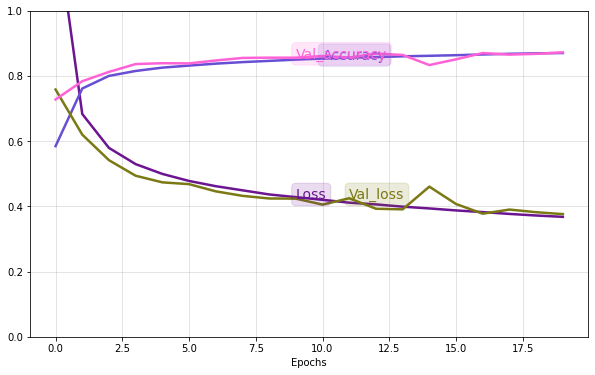

In [9]:
history_data = pd.DataFrame(history.history)

columns = history_data.columns
random_abs = np.abs(np.random.randn(len(columns), 3))
colors = np.abs(random_abs)/random_abs.max()

ys = history_data.median()
xs = history_data.agg(lambda x:np.argsort(x)[len(x)//2])

fig, ax = plt.subplots(figsize=(10, 6))

for (x, y, column, color) in zip(xs, ys, columns, colors):
    color = tuple(color)
    ax.plot(history_data[column], color = color, lw = 2.5)
    
    ax.text(x, y, column.capitalize(), fontsize = 14, color=color,  bbox=dict(boxstyle="round",
                   ec= color + (0.15,),
                   fc= color + (0.15,),
                   ))

ax.set_ylim(0, 1)
ax.set_xlabel('Epochs')
ax.grid(True, color = (0.1, 0.1, 0.1), alpha = 0.15)
plt.show()

In [10]:
# to evaluate the model
model_1.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 98.8457 - accuracy: 0.7819


[98.84574127197266, 0.7818999886512756]

In [11]:
# To predict on new records
X_new = X_test[:5].copy()
y_proba = model_1.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 96ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [12]:
# To identify the class that each new record belong
# get the index of the class with the greatest probability for each record
y_pred = np.argmax(y_proba, axis=1)
print(np.array(class_names)[y_pred])

['Ankle boot' 'Pullover' 'Trouser' 'Trouser' 'Shirt']


In [13]:
def create_model():
    
    model = Sequential()
    
    # Flattens the input. Does not affect the batch size.
    model.add(Flatten(input_shape = [28, 28]))
    
    # kernel_initializer --> distribution of weights when init 
    # activation function
    # 50 is the units output. Positive integer, dimensionality of the output space (next layer)
    model.add(Dense(50, activation=activations.relu, kernel_initializer = 'normal'))
    
    model.add(Dense(50, activation=activations.relu))
    
    model.add(Dense(50, activation=activations.relu))
    
    # Output layer. Units Output are 10. This must be equal to y.shape
    # activation sigmoid is because the y is 0-1 values
    model.add(Dense(10, activation=activations.sigmoid))

    # binary_crossentropy -> Computes the binary crossentropy loss where y = [[0, 0,.., 1], ... [0, 1,...0]]
    # sgd --> Schocastic Gradiend Descend
    model.compile(loss = 'binary_crossentropy', optimizer ='sgd', metrics = ['accuracy'])
    
    return model

In [14]:
# We transfor y = [0, 1, 0, 1, ..., 9] --> y = [[0, 0,.., 1], ... [0, 1,...0]]
y_train_trans = tf.one_hot(y_train, 10).numpy() # 10  es number of classes

model_1 = create_model()
history = model_1.fit(X_train, y_train_trans, epochs = 20, batch_size = 10 )

Epoch 1/20
5500/5500 [==============================] - 9s 2ms/step - loss: 0.2036 - accuracy: 0.6121
Epoch 2/20
5500/5500 [==============================] - 8s 1ms/step - loss: 0.1189 - accuracy: 0.7648
Epoch 3/20
5500/5500 [==============================] - 8s 1ms/step - loss: 0.1012 - accuracy: 0.8038
Epoch 4/20
5500/5500 [==============================] - 8s 1ms/step - loss: 0.0925 - accuracy: 0.8207
Epoch 5/20
5500/5500 [==============================] - 8s 2ms/step - loss: 0.0872 - accuracy: 0.8303
Epoch 6/20
5500/5500 [==============================] - 9s 2ms/step - loss: 0.0834 - accuracy: 0.8370
Epoch 7/20
5500/5500 [==============================] - 9s 2ms/step - loss: 0.0804 - accuracy: 0.8419
Epoch 8/20
5500/5500 [==============================] - 8s 1ms/step - loss: 0.0781 - accuracy: 0.8477
Epoch 9/20
5500/5500 [==============================] - 9s 2ms/step - loss: 0.0760 - accuracy: 0.8514
Epoch 10/20
5500/5500 [==============================] - 8s 1ms/step - loss: 0.074

In [59]:
y_test_trans = tf.one_hot(y_test, 10).numpy()
model_1.evaluate(X_test, y_test_trans)

313/313 [==============================] - 1s 1ms/step - loss: 10.6170 - accuracy: 0.8391


[10.617030143737793, 0.8391000032424927]

In [60]:
X_new = X_test[:5]
y_proba = model_1.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 64ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [61]:
predict_x=model_1.predict(X_new) 
y_pred=np.argmax(predict_x,axis=1)
print(np.array(class_names)[y_pred])

1/1 [==============================] - 0s 19ms/step
['Ankle boot' 'Pullover' 'Trouser' 'Trouser' 'Shirt']


## Building a Regression MLP Using the Sequential API

Data for practice the regression MLP come from `fetch_california_housing()`

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import relu, softmax, sigmoid, tanh 
from keras.losses import mean_absolute_error
from keras.optimizers import Adam, SGD, RMSprop
from keras.initializers import GlorotNormal, RandomNormal, RandomUniform, VarianceScaling

In [3]:
# Load file California housing data
housing = fetch_california_housing()

# divide the data into [full train data] = [training data, valitation data] and [test data]
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=123)
# divide the training data into [training data, valitation data]
X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full, random_state=123)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [13]:
def get_shape(X):
    return X.shape[1:]

def create_model_secuential(
    input_shape,
    activation = relu,
    activation_init = relu, 
    units_hiden : int = 50, 
    units_out:int=1, optimizer = SGD(),
    kernel_initializer = RandomNormal(),
    loss ='mse'):
    
    seed = 124
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    model = Sequential()
    # kernel_initializer --> distribution of weights when init 
    # activation function
    # 50 is the units output. Positive integer, dimensionality of the output space (next layer)
    model.add(Dense(
        units_hiden, 
        activation = activation_init, 
        kernel_initializer = kernel_initializer, 
        input_shape = input_shape))

    model.add(Dense(units_hiden, activation=activation))
    model.add(Dense(units_hiden, activation=activation))
    model.add(Dense(units_out, activation=activation))

    # sgd --> Schocastic Gradiend Descend
    model.compile(loss = loss, optimizer = optimizer)
    
    return model

In [21]:
# To train the model
model = create_model_secuential(get_shape(X_train_scaled), optimizer = Adam())

history = model.fit(
    X_train_scaled, y_train, 
    epochs = 20, 
    batch_size = 10 ,
    validation_data=(X_valid_scaled, y_valid))

# to evaluate the model
model.evaluate(X_test_scaled, y_test)

Epoch 1/20
1161/1161 [==============================] - 3s 2ms/step - loss: 0.6162 - val_loss: 0.3810
Epoch 2/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.4015 - val_loss: 0.3435
Epoch 3/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.3634 - val_loss: 0.3316
Epoch 4/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.3505 - val_loss: 0.2951
Epoch 5/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.3531 - val_loss: 0.2986
Epoch 6/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.3398 - val_loss: 0.2981
Epoch 7/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.3292 - val_loss: 0.3200
Epoch 8/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.3228 - val_loss: 0.2883
Epoch 9/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.3272 - val_loss: 0.2886
Epoch 10/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.310

0.26371175050735474

In [193]:
# to make predictions
X_new = X_test_scaled[:5].copy()
model.predict(X_new)

1/1 [==============================] - 0s 67ms/step


array([[2.0373602],
       [0.9118079],
       [1.2807661],
       [1.7926067],
       [3.4367528]], dtype=float32)

In [182]:
# we save the model.
# ww can not save a model done with `class`
model.save('assets/neural_network/california_housing_model.h5')
# we load the model
model_saved = keras.models.load_model('assets/neural_network/california_housing_model.h5')
# we evaluate the saved model
model_saved.predict(X_new)

1/1 [==============================] - 0s 50ms/step


array([[2.0373602],
       [0.9118079],
       [1.2807661],
       [1.7926067],
       [3.4367528]], dtype=float32)

## Building Complex Models Using the Functional API

* A non-sequential neural network is a Wide & Deep neural network (by Heng-Tze Cheng et al)
* It connects all or part of the inputs directly to the output layer.
* This architecture makes it possible for the neural network to learn both deep patterns (using the deep path) and simple rules (through the short path)


<img src = "https://1.bp.blogspot.com/-Dw1mB9am1l8/V3MgtOzp3uI/AAAAAAAABGs/mP-3nZQCjWwdk6qCa5WraSpK8A7rSPj3ACLcB/s1600/image04.png">

More information [WideDeepModel -> TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/experimental/WideDeepModel)

The implementation is done with a `class`

In [25]:
class WideDeep(keras.Model):

    seed = 124
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    def __init__(self, hide_units=50, out_unit = 1, activation='relu', **kwards):
        super().__init__(**kwards)
        self.hide_units = hide_units
        self.out_unit = out_unit
        self.activation = activation

    def DeepModel(self, deep_shape):
        model = Sequential()
        model.add(Dense(self.hide_units, activation=self.activation, input_shape=deep_shape))
        model.add(Dense(self.hide_units, activation=self.activation))
        model.add(Dense(self.hide_units, activation=self.activation))
        model.add(Dense(self.hide_units, activation=self.activation))
        model.add(Dense(self.out_unit, activation=self.activation))
        return model

    def CombinedModel(self, deep_shape, loss):
        combined_model =keras.experimental.WideDeepModel(self.DeepModel(deep_shape), keras.experimental.LinearModel()) 
        combined_model.compile(optimizer=['Adam', 'Adam'], loss =loss)
        return combined_model
    
    def __call__(self, linear_inputs, deep_inputs, target ,loss, epochs=20):
        deep_shape = deep_inputs.shape[1:]
        model_final = self.CombinedModel(deep_shape, loss)
        model_final.fit([linear_inputs, deep_inputs], target, epochs=epochs, batch_size=10)
        return model_final

In [26]:
widedeep = WideDeep()
models = widedeep(
    linear_inputs = X_train_scaled,
    deep_inputs = X_train_scaled, 
    target = y_train, loss='mse')

Epoch 1/20
1161/1161 [==============================] - 2s 1ms/step - loss: 1.4831
Epoch 2/20
1161/1161 [==============================] - 2s 1ms/step - loss: 0.8345
Epoch 3/20
1161/1161 [==============================] - 2s 1ms/step - loss: 0.7258
Epoch 4/20
1161/1161 [==============================] - 2s 1ms/step - loss: 0.6655
Epoch 5/20
1161/1161 [==============================] - 2s 1ms/step - loss: 0.6261
Epoch 6/20
1161/1161 [==============================] - 2s 1ms/step - loss: 0.5978
Epoch 7/20
1161/1161 [==============================] - 2s 1ms/step - loss: 0.5771
Epoch 8/20
1161/1161 [==============================] - 2s 1ms/step - loss: 0.5655
Epoch 9/20
1161/1161 [==============================] - 2s 1ms/step - loss: 0.5553
Epoch 10/20
1161/1161 [==============================] - 2s 1ms/step - loss: 0.5500
Epoch 11/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.5434
Epoch 12/20
1161/1161 [==============================] - 2s 1ms/step - loss: 0.5404
E

In [22]:
models.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.2730


0.27301719784736633

<div align = "center">
    <img src = "assets/neural_network/wide_deep_neural_network.png" height = 250px \>
    <img src = "assets/neural_network/wide_deep_neural_network_01.png" height = "250px" \>
</div >

* As the plot above show, we can used all the inputs both inputs for *deep* model and *wide*.
* In the above example we used the all inputs for both, *wide* and *deep*

In [107]:
# we can not save a model done with class
# models.save('assets/neural_network/widedeep.h5')

## Fine-Tuning Neural Network Hyperparameters

# Training Deep Neural Network

In [194]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import numpy as np

In [199]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import relu, softmax, sigmoid, tanh 
from keras.losses import mean_absolute_error
from keras.optimizers import Adam, SGD, RMSprop
from keras.initializers import GlorotNormal, RandomNormal, RandomUniform, VarianceScaling, HeUniform

In [203]:
# To train the model
model = create_model_secuential(get_shape(X_train_scaled))

history = model.fit(
    X_train_scaled, y_train, 
    epochs = 20, 
    batch_size = 10 , 
    validation_data=(X_valid_scaled, y_valid))

# to evaluate the model
model.evaluate(X_test_scaled, y_test)

Epoch 1/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.6091 - val_loss: 0.4527
Epoch 2/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.4651 - val_loss: 0.4338
Epoch 3/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.4496 - val_loss: 0.4185
Epoch 4/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.4388 - val_loss: 0.4089
Epoch 5/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.4294 - val_loss: 0.4009
Epoch 6/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.4199 - val_loss: 0.3934
Epoch 7/20
1161/1161 [==============================] - 2s 1ms/step - loss: 0.4149 - val_loss: 0.3995
Epoch 8/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.4065 - val_loss: 0.3853
Epoch 9/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.4026 - val_loss: 0.3852
Epoch 10/20
1161/1161 [==============================] - 2s 2ms/step - loss: 0.398

0.35350102186203003

# Image Segmentation

Source: [TensorFlow](https://www.tensorflow.org/tutorials/images/segmentation)



In [204]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [211]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [215]:
normalize(np.array([[9, 5.6, 200.6], [9, 5.6, 200.6]]), np.array([1, 2, 3]))

(<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[0.03529412, 0.02196078, 0.7866667 ],
        [0.03529412, 0.02196078, 0.7866667 ]], dtype=float32)>,
 array([0, 1, 2]))

In [209]:
sd = tf.cast([0.1, 0.9, 5.6], tf.int32)

In [210]:
sd.numpy()

array([0, 0, 5])

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt